A notebook to visualize how a neural network twists and folds space as it classifies the moons dataset. See this [wonderful](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) article for background.  For folks who program in JavaScript (I probably should learn), there's an incredible implementation of these same ideas [here](https://cs.stanford.edu/people/karpathy/convnetjs/), in ConvNetJS. Someday, it'd be nice to do the same in TensorFlow.js.

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.nn import sigmoid, tanh
from sklearn.datasets import make_moons

In [0]:
data, labels = make_moons()
labels = labels.astype(np.float32)

A helper function for plotting gridlines and the moons dataset.

In [0]:
def plot(data, horz_grid, vert_grid, show=True):
  for line in horz_grid:
    plt.plot(line[:,0], line[:,1], 'green', lw=0.5)
  for line in vert_grid:
    plt.plot(line[:,0], line[:,1], 'orange', lw=0.5)
  plt.scatter(data[:,0], data[:,1], c=labels, cmap='coolwarm')        
  plt.grid('off')
  plt.axis('off')
  if show: plt.show()

Draw a grid by a creating a bunch of short line segments. Later, when we transform the space, we'll find the new location of the start and end points. This will help us give the appearance of plotting curved lines.

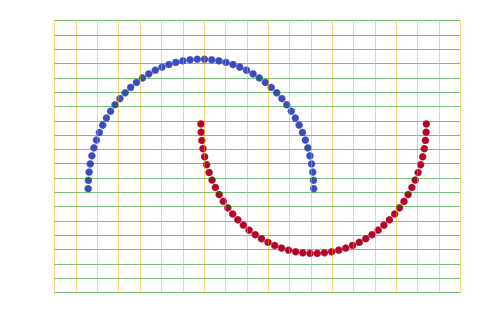

In [4]:
segments = 100 # segments per horizontal and vertical gridline
gridlines = 20 # number of horizontal and vertical gridlines
horz_pad, vert_pad = 0.3, 0.3

x_min, x_max = data[:, 0].min() - horz_pad, data[:, 0].max() + horz_pad
y_min, y_max = data[:, 1].min() - vert_pad, data[:, 1].max() + vert_pad

xx = np.linspace(x_min, x_max, segments)
yy = np.linspace(y_min, y_max, segments)

horz_grid = []
for y in np.linspace(y_min, y_max, gridlines):
  line = np.zeros((segments, 2))
  line[:,0] = xx
  line[:,1] = y
  horz_grid.append(line)
  
vert_grid = []
for x in np.linspace(x_min, x_max, gridlines):
  line = np.zeros((segments, 2))
  line[:,0] = x
  line[:,1] = yy
  vert_grid.append(line)

plot(data, horz_grid, vert_grid)

A mlp. Note we're using tanh activations (keeping the output of the intermediate layers between -1 and 1 to simplify plotting). We're also specifying the activation as part of the layer (rather than in the call method), to make it easier reuse individual layers after the network is trained. It wasn't necessary to write this using the Keras [Subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing) (I just felt like it). Finally, we're using a small number of units per layer, you can experiment with this to see the different types of visualizations produced.

In [0]:
class LittleModel(Model):
  def __init__(self):
    super(LittleModel, self).__init__()
    self.d1 = Dense(5, activation=tanh)
    self.d2 = Dense(5, activation=tanh)
    self.d3 = Dense(5, activation=tanh)
    self.d4 = Dense(5, activation=tanh)
    self.d5 = Dense(1)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    return sigmoid(self.d5(x))

Keras models can also be trained by writing a custom training [loop](https://www.tensorflow.org/tutorials/eager/custom_training), but this was not necessary here, so we'll use the convenient built-in methods. Our model has a small number of units, so it may take a while to converge. I'll be fitting for a number of epochs, so have written ```verbose=0``` to keep things neat.

In [6]:
model = LittleModel()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(data, labels, epochs=400, verbose=0)
model.evaluate(data, labels)

4/4 [==============================] - 0s 3ms/step


[0.007781731449067592, 1.0]

While we're at it, here's how to plot the decision boundary using a meshgrid. This isn't the main goal of this notebook, but thought I'd include it along the way, since I always love seeing this in sklearn examples.

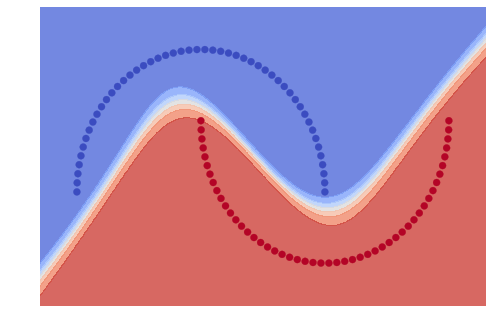

In [7]:
gx, gy = np.meshgrid(xx, yy)
Z = model.predict(np.c_[gx.ravel(), gy.ravel()])
Z = Z.reshape(gx.shape)
plt.contourf(gx, gy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(data[:,0], data[:,1], c=labels, cmap='coolwarm')

axes = plt.gca()
axes.set_xlim([x_min, x_max])
axes.set_ylim([y_min, y_max])
plt.grid('off')
plt.axis('off')
plt.show()

Now for the fun part. Show how the dataset and gridlines appear after they're transformed by each layer. Also note, in our plot function we're using only the first two weights from each layer (there are more views available). If you run this notebook again, you'll get different results, thanks to the random initialization of the weights.

Initial space


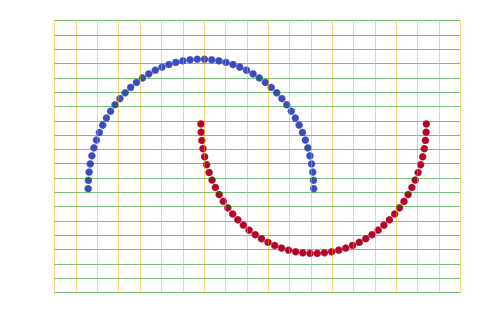

Space after layer 1


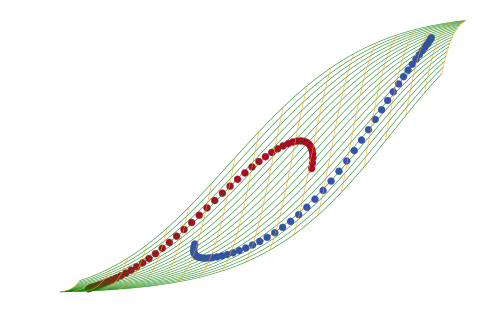

Space after layer 2


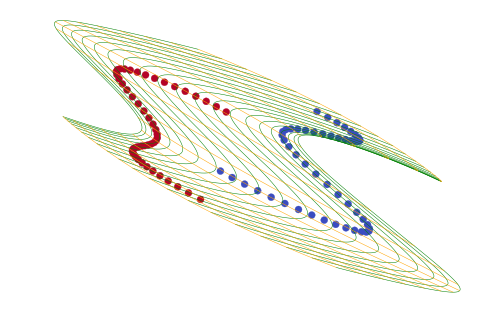

Space after layer 3


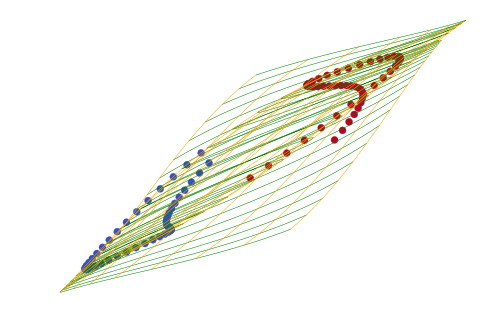

Space after layer 4


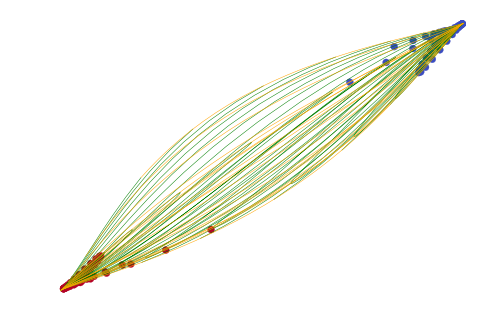

In [8]:
d, h, v = data, horz_grid, vert_grid

print("Initial space")
plot(data, horz_grid, vert_grid)

for i, layer in enumerate(model.layers[:-1]):
    print("Space after layer %d" % (i + 1))
    
    # Isn't this cool? We can grab the layer from the model (with the
    # trained weights) and call it on the data.
    d, h, v = layer(d), layer(h), layer(v)
    plot(d, h, v)

I'd like to produce clean code to animate how the data is transformed layer by layer. I'll update this if I have a chance down the road. In the meantime, here's a way to animate how it looks one layer at a time. I think this is less interesting than the pictures above, but since I'm new to animating with matplotlib, wanted to try it out.

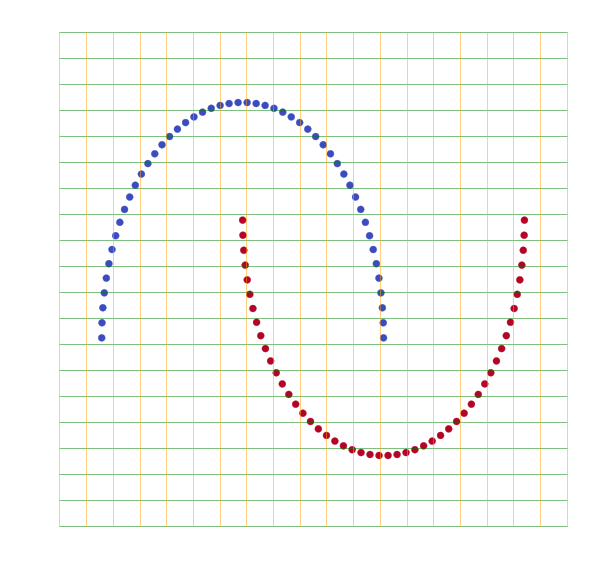

In [9]:
# Note: I'm not a matplotlib wizard, I'm sure there's a more efficient 
# way to do this. The code is here mostly as a reminder to myself how it works.
fig = plt.figure(figsize=(10,10))
ax = plt.axes(xlim=(-1.0, 1.0), ylim=(-1.0, 1.0))

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15)

model = LittleModel()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

data_hist, h_hist, v_hist = [data], [horz_grid], [vert_grid]

layer = model.layers[0]
epochs = 100
for epoch in range(epochs):
    model.fit(data, labels, epochs=1, verbose=0)   
    # Note that if you choose to visualize a later layer, you'll 
    # need to forward the data through the earlier ones first.
    d, h, v = layer(data), layer(horz_grid), layer(vert_grid)
    data_hist.append(d)
    h_hist.append(h)
    v_hist.append(v)
    
def update(i):
    #print("drawing", i)
    fig.clf()
    plot(data_hist[i], h_hist[i], v_hist[i], show=False)
    
ani = animation.FuncAnimation(fig, update, frames=epochs, repeat=False)

# If you're running this notebook in Colab, you can download this
# from the files browser, hidden in the table of contents menu.
ani.save("layer.mp4", writer=writer)

That's it!